# Setup

## Imports & Settings

In [3]:
%load_ext autoreload
%autoreload 2

import os
import re
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Column Names (from Metadata & To Be Created)
col_sample_id_o, col_sample_id = "Sample ID", "Sample"  # in metadata, new
col_subject = "Patient"  # in metadata file
col_inflamed, col_stricture = "Inflamed", "Stricture"  # in metadata file
col_condition = "Condition"  # constructed from col_inflamed & col_stricture
col_fff = "file_path"  # column in metadata in which to store data file path
col_tangram = "tangram_prediction"  # for future Tangram imputation annotation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Options & Data

In [36]:
# Directories & Metadata
load, reannotate = True, True
samples = "all"
# run = ["CHO-001"] * 3 + ["CHO-002"] * 2
# samples = ["50452A", "50452B", "50618B5", "50564A4",
#            "50452C", "50007B2", "50115A2", "50445A3", "49471A4"]
# samples = ["50452A", "50452B", "50452C", "50618B5", "50564A4"]
run = ["CHO-005"] * 2 + ["CHO-006"] * 2
samples = ["50007B2", "50115A2", "50445A3", "49471A4"]
# run = ["CHO-008", "CHO-009", "CHO-010"]
# samples = ["50564A4", "50618B5"]
# samples = ["50007B2"]
# samples = ["50006B", "50006A", "50006C"]
# run = ["CHO-008", "CHO-008", "CHO-009"]
# samples = ["50217B", "50217A", "50217C"]
# run = ["CHO-007", "CHO-007", "CHO-008", "CHO-008", "CHO-010", "CHO-010"]
# samples = ["50006A", "50006B", "50217B", "50217A", "50336C", "50336B"]
# samples = ["50336C", "50336B", "50336A"]
# samples = ["50452A", "50452B", "50452C"]
# samples = ["50564A4", "50618B5"]

# Optionally, Define Manual Annotation Versions
# should be stored in ("<out_dir>/annotations_dictionaries")
# in format <selves[i]._library_id>___leiden_<man_anns[i]>_dictionary.xlsx
# with first column = leiden cluster and second column = annotation
man_anns = True  # load manual annotations according to clustering kws
# man_anns = ["res0pt5_dist0pt5_npc30", "res0pt75_dist0pt3_npc30",
#             "res1pt5_dist0_npc30"]  # choose manual annotations to load
# man_anns = None  # do not load manual annotations

# Main Directories
# Replace manually or mirror my file/directory tree in your home (`ddu`)
ddu = os.path.expanduser("~")
ddm = "/mnt/cho_lab" if os.path.exists("/mnt/cho_lab") else "/mnt"  # Spark?
ddl = f"{ddm}/disk2/{os.getlogin()}/data/shared-xenium-library" if (
    "cho" in ddm) else os.path.join(ddu, "shared-xenium-library")
ddx = f"{ddm}/bbdata2"  # mounted drive Xenium folder
out_dir = os.path.join(ddl, "outputs", "TUQ97N", "nebraska")  # None = no save
d_path = os.path.join(ddm, "disk2" if "cho" in ddm else "",
                      os.getlogin(), "data")  # other, e.g., Tangram data
anf = pd.read_csv(os.path.join(ddu, "corescpy/examples/markers_lineages.csv"))
file_mdf = os.path.join(ddl, "samples.csv")  # metadata

# Annotation & Tangram Imputation
col_assignment = "Bin"  # which column from annotation file to use
# col_cell_type_sc, file_sc = "ClusterAnnotation", str(
#     f"{d_path}/2023-05-12_CombinedCD-v2_ileal_new.h5ad")
col_cell_type_sc, file_sc = "cell_type", f"{d_path}/elmentaite_ileal.h5ad"
# file_sc = None  # to skip Tangram imputation/label transfer

# Processing & Clustering Options
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[15, None],
              cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              method_norm="log")  # preprocessing keyword arguments
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=list(anf.iloc[:, 0]),  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
kws_clustering, col_assignment = {}, []
for i in zip([0.5, 0.75, 1.5], [0.5, 0.3, 0], [30, 30, 30]):
    kws = {**kws_cluster, "resolution": i[0], "kws_umap": {
        **kws_cluster["kws_umap"], "min_dist": i[1]}, "n_comps": i[2]}
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})
    col_assignment += ["group" if kws["resolution"] >= 0.7 else "Bucket"]
if man_anns is True:
    man_anns = list(kws_clustering.keys())
col_cell_type = list(kws_clustering.keys())[-1] if (
    man_anns is None) else f"manual_{man_anns[-1]}"  # default cell labels

# After this point, no more options to specify
# Just code to infer the data file path from your specifications
# and construct argument dictionaries and manipulate metadata and such.

# Read Metadata & Other Information
metadata = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_o).loc[samples].reset_index()

# Revise Metadata & Construct Variables from Options
metadata.loc[:, col_condition] = metadata.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
metadata.loc[:, col_sample_id] = metadata[[col_condition, col_sample_id_o]
                                          ].apply("-".join, axis=1)
metadata = metadata.set_index(col_sample_id)
fff = np.array(cr.pp.construct_file(run=run, directory=ddx))
bff = np.array([os.path.basename(i) for i in fff])  # base path names
samps = np.array([i.split("__")[2].split("-")[0] for i in fff])
for x in metadata[col_sample_id_o]:
    m_f = metadata[metadata[col_sample_id_o] == x][
        "out_file"].iloc[0]  # ...use to find unconventionally-named files
    locx = np.where(samps == x)[0] if pd.isnull(
        m_f) else np.where(bff == m_f)[0]
    metadata.loc[metadata[col_sample_id_o] == x, col_fff] = fff[locx[0]] if (
        len(locx) > 0) else np.nan  # assign output file to metadata row
metadata = metadata.dropna(subset=[col_fff]).drop_duplicates()

# Annotation File
assign = anf.dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene")  # markers
# assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers

# Print Metadata & Make Output Directory (If Not Present)
print(metadata)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load Data
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=col_cell_type)  # object creation arguments
selves = [None] * metadata.shape[0]  # to hold different samples
for i, x in enumerate(metadata.index.values):
    selves[i] = cr.Spatial(metadata.loc[x][col_fff], library_id=x, **kws_init)
    for j in metadata:  # iterate metadata columns
        selves[i].rna.obs.loc[:, j] = str(metadata.loc[x][j])  # add to object
    selves[i].rna.obs.loc[:, "out_file"] = os.path.join(
        out_dir, selves[i]._library_id)  # output path (to save object)
    if load is True:
        if os.path.exists(str(selves[i].rna.obs.out_file.iloc[0]) + ".h5ad"):
            selves[i].update_from_h5ad(selves[i].rna.obs.out_file.iloc[0])
        print(selves[i].rna)

# Marker Gene Dictionary (for Scanpy Plotting)
marker_genes_dict = dict(assign["Bucket"].reset_index().groupby(
    "Bucket").apply(lambda x: list(pd.unique(list(set(
        x.Gene).intersection(selves[0].rna.var_names))))))  # to dictionary

                  Sample ID  Patient     Status  Slide Id          Project  \
Sample                                                                       
Stricture-50007B2   50007B2    50007  Available   10933.0  scRNA & Spatial   
Stricture-50115A2   50115A2    50115  Available   10926.0  scRNA & Spatial   
Stricture-50445A3   50445A3    50445  Available   10923.0  scRNA & Spatial   
Stricture-49471A4   49471A4    49471  Available   10490.0  scRNA & Spatial   

                         Location Stricture  GRID ID  Inflamed Procedure Date  \
Sample                                                                          
Stricture-50007B2  Terminal Ileum       yes  1011314  inflamed        2023-11   
Stricture-50115A2  Terminal Ileum       yes  1011316  inflamed        2023-11   
Stricture-50445A3  Terminal Ileum       yes  1011337  inflamed        2023-12   
Stricture-49471A4  Terminal Ileum       yes  1011292  inflamed        2023-10   

                   Age     Sex   Race Hispan

## Manual Annotations

### Load Manual Annotations

In [37]:
if man_anns is not None and man_anns is not False:
    for i, s in enumerate(selves):
        for r in man_anns:  # iterate Leiden clusterings
            fmr = os.path.join(out_dir, "annotation_dictionaries", str(
                f"{s._library_id}___leiden_{r}_dictionary.xlsx"))  # mappings
            if os.path.exists(fmr) is False:
                print(f"{fmr} file NOT found.")
                continue
            else:
                print(f"{fmr} file found.")
            if f"leiden_{r}" not in s.rna.obs:
                print(f"leiden_{r} not found in adata")
                continue
            fmr = pd.read_excel(fmr).iloc[:, :2].astype(str)
            mans = dict(fmr.set_index(fmr.columns[0]).iloc[:, 0])
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[f"leiden_{r}"].astype(
                int).astype(str).replace(mans)  # Leiden -> manual annotation
            s.rna.obs.loc[s.rna.obs[f"manual_{r}"].isnull(
                ), f"manual_{r}"] = s.rna.obs.loc[s.rna.obs[
                    f"manual_{r}"].isnull(), f"leiden_{r}"].astype(
                        str)  # missing annotations replaced with Leiden
            s.rna.obs.loc[:, f"manual_{r}"] = s.rna.obs[
                f"manual_{r}"].astype("category")  # as categorical
            # s.plot_spatial(f"manual_{r}")

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Stricture-50007B2___leiden_res0pt5_dist0pt5_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Stricture-50007B2___leiden_res0pt75_dist0pt3_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Stricture-50007B2___leiden_res1pt5_dist0_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Stricture-50115A2___leiden_res0pt5_dist0pt5_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries/Stricture-50115A2___leiden_res0pt75_dist0pt3_npc30_dictionary.xlsx file NOT found.
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/

### Write Manual Annotations

In [38]:
if man_anns not in [None, False] and out_dir is not None:
    for i, s in enumerate(selves):
        for r in man_anns:
            if f"manual_{r}" in s.rna.obs:
                s.write_clusters(out_dir, col_cell_type=f"manual_{r}",
                                 overwrite=True,
                                 file_prefix=f"{s._library_id}__")
        s.write(s.rna.obs.out_file.iloc[0])

# Clustering

## Processing, Leiden, Annotation

In [ ]:
%%time

print("\n\n", kws_pp, "\n\n")
for i, s in enumerate(selves):
    f_o = str(selves[i].rna.obs.out_file.iloc[0])

    # Preprocessing
    if load is False:
        _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

    # Clustering at Different Resolutions & Minimum Distances
    for j, x in enumerate(kws_clustering):

        # Variables & Output Files
        print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
        annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

        # Clustering, Markers, Annotation, & Writing Output
        if load is False or cct not in s.rna.obs:
            _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
        if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
            _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
        if reannotate is True or load is False:  # annotate; Explorer files
            _ = s.annotate_clusters(annot, col_cell_type=cct,
                                    col_annotation=cca)  # annotate
            for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
                s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
                                 file_prefix=f"{s._library_id}__", n_top=True)

        # Write Final Object
        if load is False or reannotate is True and f_o is not None:
            s.write(f_o)

In [ ]:
# %%time

# print("\n\n", kws_pp, "\n\n")
# for i, s in enumerate(selves):
#     f_o = str(selves[i].rna.obs.out_file.iloc[0])

#     # Preprocessing
#     if load is False:
#         _ = s.preprocess(**kws_pp, figsize=(15, 15))  # preprocess

#     # Clustering at Different Resolutions & Minimum Distances
#     for j, x in enumerate(kws_clustering):

#         # Variables & Output Files
#         print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n")
#         cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns
#         annot = assign[[col_assignment[j]]]  # gene-annotation dictionary

#         # Clustering, Markers, Annotation, & Writing Output
#         if load is False:
#             _ = s.cluster(**kws_clustering[x], key_added=cct, out_file=f_o)
#         if load is False or f"rank_genes_groups_{cct}" not in s.rna.uns:
#             _ = s.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs
#         if reannotate is True or load is False:  # annotate; Explorer files
#             _ = s.annotate_clusters(annot, col_cell_type=cct,
#                                     col_annotation=cca)  # annotate
#             for c in [k for k in [cct, cca] if k in s.rna.obs]:  # Explorer
#                 s.write_clusters(out_dir, col_cell_type=c, overwrite=True,
#                                  file_prefix=f"{s._library_id}__", n_top=True)

#         # Write Final Object
#         if load is False or reannotate is True and f_o is not None:
#             s.write(f_o)

## Tangram Imputation

In [ ]:
%%time

if file_sc is not None:
    adata_sc = sc.read(file_sc)  # read whole tx'ome data for imputation
    if load is False:
        for i, s in enumerate(selves):
            out = s.impute(
                adata_sc.copy(), col_cell_type=col_cell_type_sc,
                mode="clusters", markers=None, plot=False, plot_density=False,
                plot_genes=None, col_annotation=col_tangram, out_file=None)
            out[0].write_h5ad(os.path.splitext(selves[
                0].rna.obs.out_file.iloc[0])[0] + "___tangram.h5ad")  # write
            s.write(s.rna.obs.out_file.iloc[0])
            s.write_clusters(out_dir, file_prefix=f"{s._library_id}___",
                             col_cell_type=col_tangram,
                             overwrite=True, n_top=True)
    s.plot_spatial(color=col_tangram)

## Plot Clusters

In [ ]:
for s in selves:
    s.plot_spatial(color=col_tangram)
    for j, x in enumerate(kws_clustering):
        _ = s.plot_spatial(color=[f"leiden_{x}",, f"label_{x}"])

## ToppGene & Marker Expression

In [78]:
self = selves[0]
print(self._library_id)
self.get_layer("counts", inplace=True)

srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
# c_t = "leiden_res0pt5_dist0pt5_npc30"
# c_t = "leiden_res0pt75_dist0pt3_npc30"
c_t = "leiden_res1pt5_dist0_npc30"
tgdf, mks = self.annotate_clusters(
        None, sources=srcs, col_cell_type=c_t, max_results=10000,
        name_pattern={srcs[0]: "SmallIntestine"}, p_threshold=1e-15,
        lfc_threshold=1.5, n_top_genes=20, n_top_annotations=40)
tgdf.loc[:, "Name"] = tgdf.Name.str.strip(
        " / Per Region, Age_group, Lineage, cell class, cell type   ").apply(
                lambda x: re.sub("SmallIntestine", "SmInt", " --- ".join(
                        x.split("|")[0].split("-"))))

Uninflamed-50217B


### By Top Markers

In [100]:
key_cluster = "14"
count_threshold = 1

print(tgdf.loc[key_cluster].iloc[:, :-3])
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=2,
    count_threshold=count_threshold, p_threshold=1e-15,
    print_threshold=15, n_top_genes=40)
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n\t", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

                                                                                  Name  \
0                                    SmInt_Pediatric_IBD --- Hematopoietic --- Myeloid   
1  SmInt_Pediatric_IBD --- Hematopoietic --- Myeloid --- MMP9+_Inflammatory_macrophage   

                                                                                     Genes  \
0  [SPI1, IDO1, LYZ, S100A8, S100A9, JAML, HCK, PLAUR, NAMPT, CXCL9, MMP9, CSF2RA, FCER1G]   
1                 [SPI1, LYZ, S100A9, CTSH, HCK, PLAUR, CXCL9, APOE, MMP9, CSF2RA, FCER1G]   

   GenesInTerm  GenesInQuery  GenesInTermInQuery  TotalGenes        PValue  
0          199            20                  13       45650  1.040117e-26  
1          196            20                  11       45650  1.116972e-21  

Count Threshold: 1


 group
BEST2+ Goblet cell                              IL1R2
CLP                              FCER1G, TYROBP, LST1
FCRL4+ Memory B                                 LRRK2
FDC                     

,BEST2+ Goblet cell,CLP,FCRL4+ Memory B,FDC,Glia 3 (BCAN+),ILCP,LEC6 (ADAMTS4+),LTi-like NCR+ ILC3,Lymphoid DC,MMP9+ Inflammatory macrophage,MPO+ Mono-Neutrophil,MPO+ mono-neutrophil,Mesothelium (PRG4+),Microfold cell,Monocytes,NK cell,Neural,Pre-B,Proximal progenitor,Stromal 1 (CCL11+),Stromal 4 (MMP1+),T_NK_cells,Tuft,cDC1,cDC2,pDC
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,
APOC1,,,,,,,,,,15%,,,,,,,,,,,,,,,,
APOE,,,,,33%,,,,,33%,,,,,,,33%,,33%,33%,,,,,,
CEBPB,,,,,,,35%,,,,,,,,,,,,,,,,,,,
CHI3L1,,,,,,,,,,,,,,,,,,,,,42%,,,,,
CSF2RB,,,,22%,,,,,,,,,,,,,,,,,,,,,,
FCER1G,,50%,,,,,,,,,,,,,,50%,,,,,,50%,,,,
HCK,,,,,,,,,,,,,,,,,,34%,,,,,34%,,,
IDO1,,,,,,,,,,,,,,,,,,,,,,,,28%,,
IL1R2,47%,,,,,,,,,,,,,,,,,,,,,,,,,


### By Genes

In [81]:
key_cluster = "1"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=[
        "LGR5", "CCL25", "CDCA7", "TOP2A",
        "MUC2", "MUC5B", "MUC1", "MUC4", "KLK1", "ZG16", "BEST2",
        "BEST4", "CCL20"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

KeyboardInterrupt: 

In [36]:
key_cluster = "10"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=[
        "LGR5", "CCL25", "CDCA7", "TOP2A",
        "MUC2", "MUC5B", "MUC1", "MUC4", "KLK1", "ZG16", "BEST2",
        "BEST4", "CCL20"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")


Count Threshold: 1


 group
BEST2+ Goblet cell    MUC2, MUC5B, MUC1, MUC4, KLK1, ZG16, BEST2
BEST4+ epithelial                                          BEST4
Cycling Stromal                                            TOP2A
Epithelial                 MUC5B, MUC1, KLK1, ZG16, BEST2, BEST4
Epithelial (TA)                                            TOP2A
ILC3                                                       CCL20
Microfold cell                                             CCL20
Stem cells                                    LGR5, CCL25, CDCA7
cycling ENCC/glia                                          CDCA7
cycling neuroblast                                         TOP2A
cycling stromal                                            TOP2A
dtype: object 

           10   Other   Total  Percent_Total
Gene                                       
TOP2A  12810   10518   23328             54
CDCA7  22829   34817   57646             39
MUC4    7132   13666   20798             34
BEST2   1384    274

,BEST2+ Goblet cell,BEST4+ epithelial,Cycling Stromal,Epithelial,Epithelial (TA),ILC3,Microfold cell,Stem cells,cycling ENCC/glia,cycling neuroblast,cycling stromal
Gene,,,,,,,,,,,
BEST2,4%,,,4%,,,,,,,
BEST4,,2%,,2%,,,,,,,
CCL20,,,,,,4%,4%,,,,
CCL25,,,,,,,,96%,,,
CDCA7,,,,,,,,74%,74%,,
KLK1,45%,,,45%,,,,,,,
LGR5,,,,,,,,12%,,,
MUC1,47%,,,47%,,,,,,,
MUC2,49%,,,,,,,,,,


In [ ]:
key_cluster = "22"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bin == "SMC"].index.intersection(self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

In [11]:
key_cluster = "24"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bucket == "T Cell"].index.intersection(
            self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")


Count Threshold: 1


 group
Activated CD4 T                                                   GPR183, SOCS3, CH25H
B Cell                                                                           CD79A
CD8 Tmem                                                                          GZMK
CLP                                                         TYROBP, FCER1G, NKG7, CD3E
CX3CR1+ CD8 Tmem                                                     FLNA, TBX21, GNLY
Cycling B cell                                                           TUBA1B, HMGB2
Cycling Stromal                                                          TUBA1B, HMGB2
Cytotoxic/CD8 T Cells                                                       GNLY, GZMB
DZ GC cell                                                                        IRF8
Distal progenitor                                                                 FLNA
EC cells (NPW+)                                                                 IGFBP3
Endothelial   

,Activated CD4 T,B Cell,CD8 Tmem,CLP,CX3CR1+ CD8 Tmem,Cycling B cell,Cycling Stromal,Cytotoxic/CD8 T Cells,DZ GC cell,Distal progenitor,EC cells (NPW+),Endothelial,FCRL4+ Memory B,FDC,Glia 1 (DHH+),ILC1,IgA plasma cell,Lymphoid DC,MAIT cell,MPO+ mono-neutrophil,Macrophages,Mast cell,Monocytes,N cells (NTS+),NK cell,Neural,Pre-B,SELL+ CD8 T,SMC (PLPP2+),STAT1+ Naive B,Stem cells,Stromal 2 (CH25H+),T cell,TRGV2 gdT,TRGV4 gdT,TRGV5/7 gdT,T_NK_cells,Tuft,cDC1,cycling EC,cycling neuroblast,cycling stromal,mLN Stroma (FMO2+),myofibroblast,myofibroblast (RSPO2+),pDC
Gene,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BACH2,,,,,,,,,,,,,,,,,,,,,,,,,,,2%,2%,,,,,,,,,,,,,,,,,,
CD3D,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,57%,,,,,,,,,,,,,
CD3E,,,,85%,,,,,,,,,,,,,,,,,,,,,,,,,,,,,85%,,,,,,,,,,,,,
CD4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,12%,,,,,,,,,,,,,
CD79A,,1%,,,,,,,,,,,,1%,,,,,,,,,,,,,,1%,,,,,,,,,,,,,,,,,,
CDKN1A,,,,,,,,,,,,,,,,,,42%,,,,,,42%,,,,,,,,,,,42%,,,,,,,,,,,
CH25H,0%,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0%,,,,,,,,,,,,,,
CMC1,,,,,,,,,,,,,,,,,,,,,,,,,3%,,,,,,,,,,,,3%,,,,,,,,,
CREM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,14%,,,,,,,,,,,


In [22]:
key_cluster = "30"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    count_threshold=1, p_threshold=1, n_top_genes=list(assign[
        assign.Bucket == "Neural-Glia"].index.intersection(self.rna.var_names)))
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n", msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

TypeError: sequence item 1: expected str instance, int found

### Sensitivity: % of Total Cells (Restricted to Comparison)

In [ ]:
# comp = ["0", "5", "8", "10", "18", "20", "34"]
comp = ["2", "7", "11", "21", "28"]
count_threshold = 1
key_cluster = "2"
_, percs_exp, n_exp, genes, msg = self.print_markers(
    key_cluster, assign, col_cell_type=c_t, lfc_threshold=None,
    key_compare=comp, count_threshold=count_threshold, p_threshold=1,
    n_top_genes=list(assign[assign.Lump == "Epithelial"].index.intersection(
        self.rna.var_names)) + ["TP53", "PLAUR"])
print("\n\n", genes, "\n\n", n_exp.applymap(int), "\n\n")
print(msg)
percs_exp.applymap(lambda x: x if x == "" else str(int(x)) + "%")

# Analyze

## Centrality Scores

In [12]:
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/annotation_dictionaries

'/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska'

	*** Building connectivity matrix...
	*** Computing & plotting centrality scores...
ERROR: Unable to fetch palette, reason: 'manual_res1pt5_dist0_npc30_colors'. Using `None`.
	*** Computing interaction matrix...
	*** Building connectivity matrix...


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'manual_res1pt5_dist0_npc30' not found in columns."

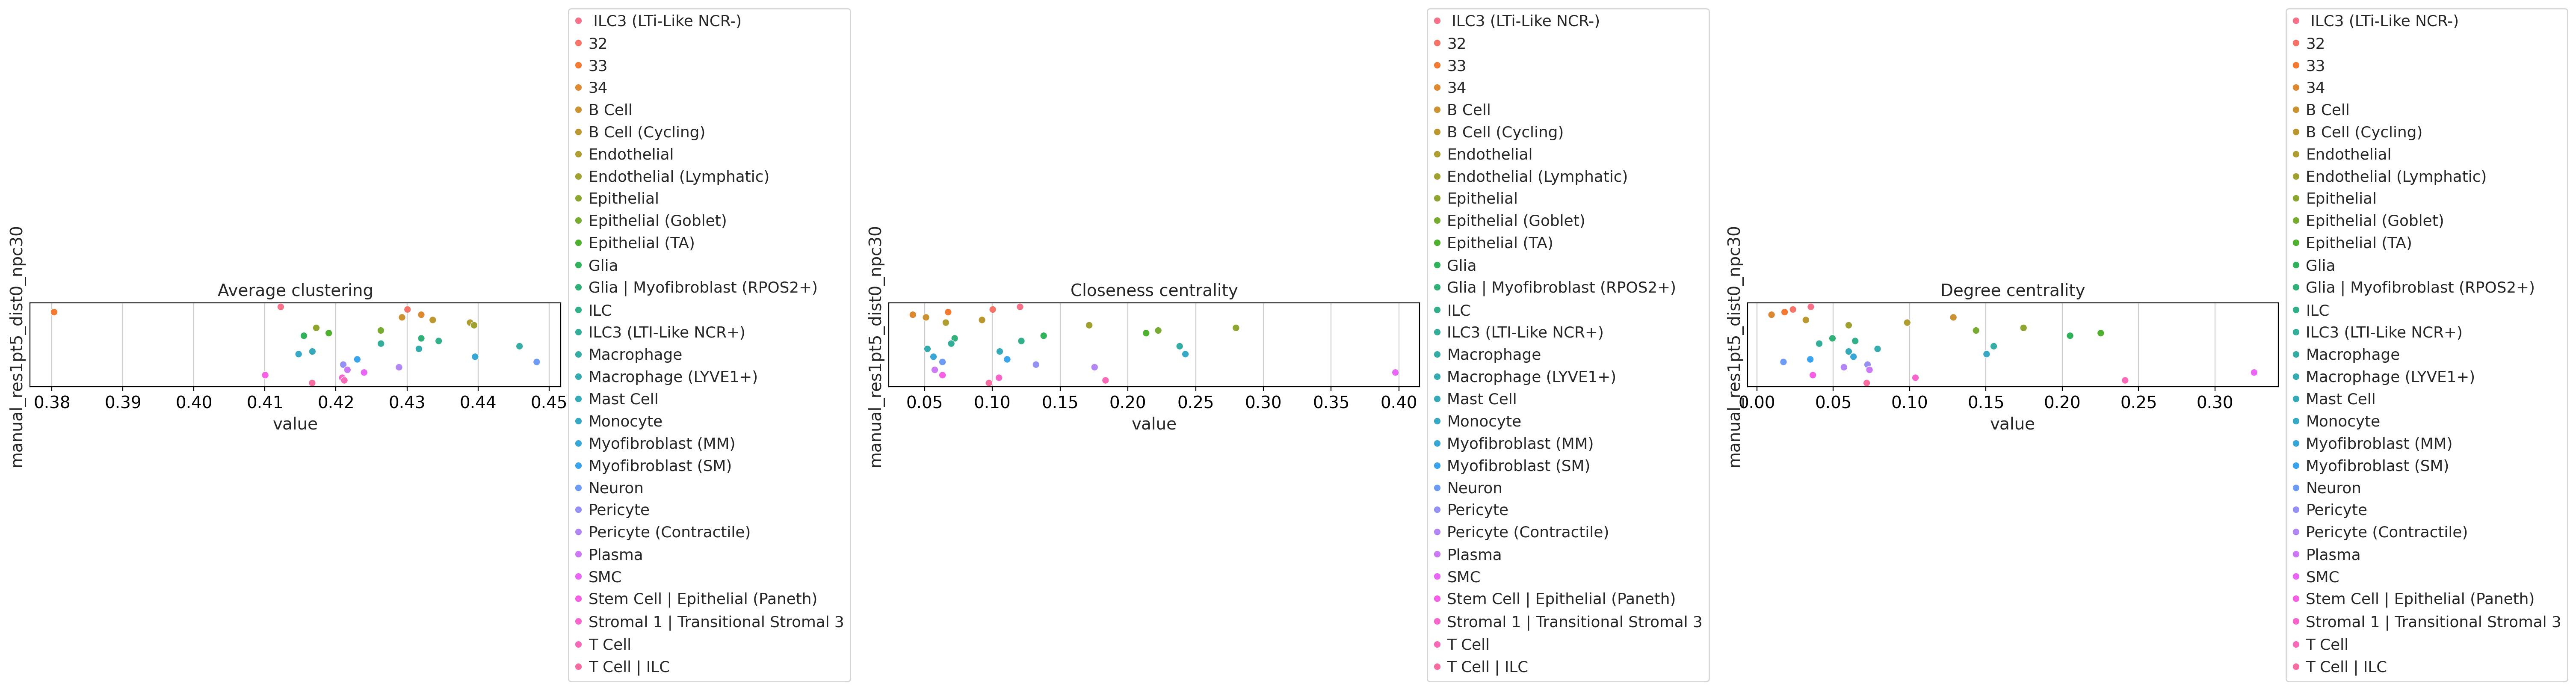

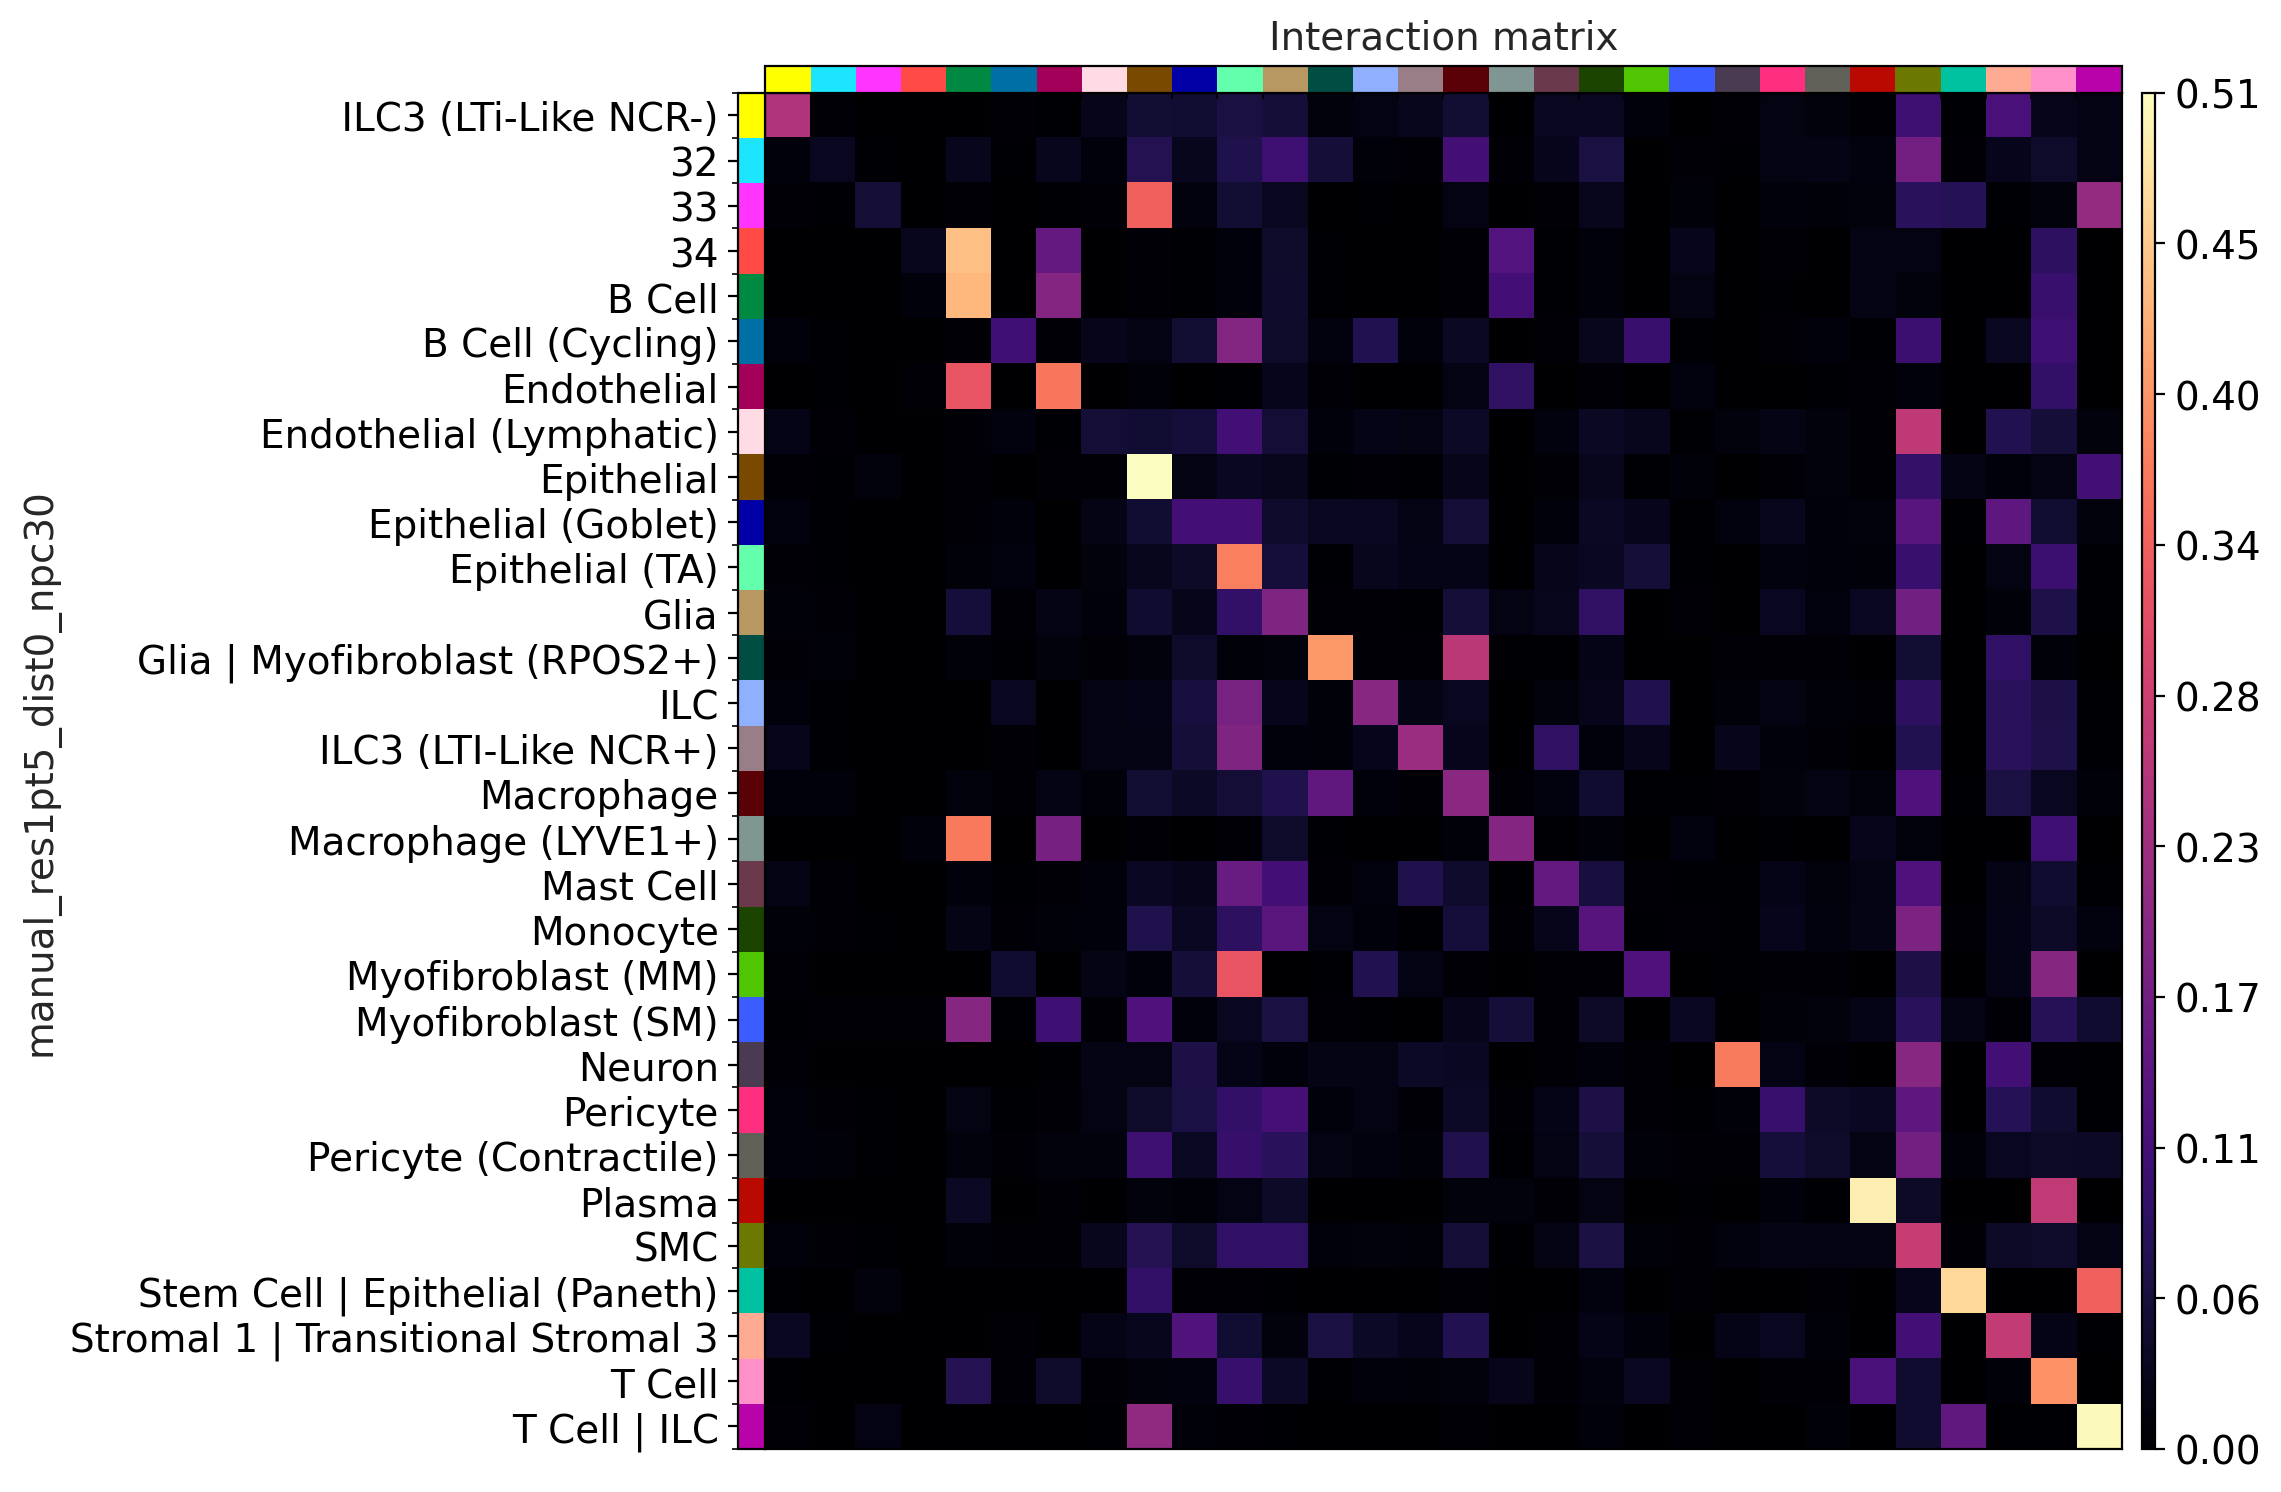

In [7]:
%%time

for s in selves:
    s.calculate_centrality(n_jobs=sc.settings.n_jobs)

## Neighborhood Enrichment Analysis

In [ ]:
%%time

for s in selves:
    _ = s.calculate_neighborhood(figsize=(60, 30))

## Cell Type Co-Occurrence

In [ ]:
%%time

for s in selves:
    _ = s.find_cooccurrence(figsize=(60, 20), kws_plot=dict(wspace=3))

## Spatial Clustering

In [ ]:
for s in selves:
    cct = f"leiden_spatial_{list(kws_clustering.keys())[-1]}"
    _ = s.cluster_spatial(key_added=cct,
                          **kws_clustering[list(kws_clustering.keys())[-1]])
    _ = s.find_markers(col_cell_type=cct, kws_plot=False)
    _ = s.annotate_clusters(assign[[col_assignment[-1]]], col_cell_type=cct,
                            col_annotation=f"annotation_{cct}")
    for c in [cct, f"annotation_{cct}"]:
        s.plot_spatial(c)
        if out_dir is not None:
            s.write_clusters(out_dir, col_cell_type=c,
                             n_top=True, overwrite=True,
                             file_prefix=f"{s._library_id}___")
    if out_dir is not None:
        s.write(str(s.rna.obs.out_file.iloc[0]))

## Spatially-Variable Genes

In [ ]:
%%time

kws = dict(kws_plot=dict(legend_fontsize="large"), figsize=(15, 15))
for s in selves:
    _ = s.find_svgs(genes=15, method="moran", n_perms=10, **kws)

## Receptor-Ligand Interactions

In [ ]:
%%time

for s in selves:
    kss, ktt = None, None
    _ = s.calculate_receptor_ligand(
        col_condition=False, p_threshold=0.01, remove_ns=True,
        figsize=(30, 20), top_n=25, key_sources=kss, key_targets=ktt)
    # s.calculate_receptor_ligand_spatial()

## Cell Type Composition 

In [ ]:
for s in selves:
    s.run_composition_analysis()

## GEX

In [ ]:
for s in selves:
    s.plot_spatial(color=["TNF", "IL23", col_cell_type])

In [ ]:
_ = self.calculate_spatial_distance("LTi-like NCR+ ILC3", genes="CSF2RB")

In [ ]:
adata = selves[0].rna.copy()
adata.X = adata.layers["counts"]
sq.tl.var_by_distance(
    adata, "LTi-like NCR+ ILC3", col_cell_type, library_key=col_sample_id,
    design_matrix_key="design_matrix", covariates=["Patient", "Inflamed"],
    metric="euclidean", spatial_key=self._spatial_key, copy=False)
sq.pl.var_by_distance(
    adata=adata, var=["CSF2RB", "CSF2RA", "IL7R"],
    anchor_key="LTi-like NCR+ ILC3",
    covariate="Inflamed")

# Workspace

In [ ]:
mks = pd.read_csv("/mnt/cho_lab/disk2/jiayuzh/projects/perianal-cd/analysis"
                  "/coreSC/output/output_2024-05-06_11.53.33/all_markers.csv",
                  index_col=0).rename_axis("gene_ix").reset_index(
                      ).set_index(["cluster", "gene"])
srcs = ["Cells of the human intestinal tract mapped across space and time",
        "Human Ileal Epithelial cells from Crohn’s Disease",
        "Human Ileal Immune cells from Crohn’s Disease"]
kwarg = dict(sources=srcs, max_results=10000,
              name_pattern={srcs[0]: "SmallIntestine"})
nta, ntg = 40, 20
mmm = mks[mks.p_val_adj <= 1e-15]
mmm = mmm[mmm.avg_log2FC >= 0.75]  # filter ~ LFC
mmm = mmm.groupby("cluster").apply(lambda x: x.iloc[:min(x.shape[
    0], ntg)]).reset_index(0, drop=True)  # only N top
types = mmm.reset_index().cluster.unique()
tgdf = pd.concat([cr.tl.get_topp_gene(
    list(mmm.loc[x].index.values), **kwargs, verbose=False).drop(
        "Source", axis=1).reset_index(0, drop=True).iloc[:nta]
    for x in types], keys=types)  # ToppGene results

In [ ]:
clus = 5
mcm = mmm[(mmm["pct.1"] >= 0.5) & (mmm["pct.2"] <= 0.33)].loc[clus]
ggg = list(mcm.iloc[:30].index)
print(", ".join(ggg), "\n")
mcm

In [ ]:
ggg = list(mmm.loc[clus].iloc[:30].index)
print(", ".join(ggg), "\n")
print(assign.loc[assign.index.intersection(ggg)].rename_axis(
    "gene").reset_index().groupby("group").apply(
        lambda x: ", ".join(x.gene.unique())))
tgdf.loc[clus]

## Manual Annotations

### Uninflamed-50452A

In [ ]:
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
s.get_layer("counts", inplace=True)
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "9"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79A"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][:, "CD79B"].X > 0))
print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "6"][
    :, "ADAMDEC1"].X > 0))

In [ ]:
for x in ["COL1A1", "PEG10", "RCN3"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "10"][:, x].X > 0))

In [ ]:
for x in ["BMP5", "F3", "MMP11", "CCL8", "NPY", "CH25H"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "15"][:, x].X > 0))

In [ ]:
for x in ["LGR5"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "16"][:, x].X > 0))

In [ ]:
for x in ["CRIP2", "KCNA5", "LBH", "NET1", "PLN", "RERGL"]:
    print(round(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "20"][:, x].X > 0) * 100, 0))

In [ ]:
for x in ["TPSAB1", "CMA1"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "21"][:, x].X > 0))

In [ ]:
for x in ["GNLY", "GZMB"]:
    print(np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "23"][:, x].X > 0))

In [ ]:
for x in marker_genes_dict["Pericyte"]:
    print(int(100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == "25"][
        :, x].X > 0)), " vs. ", int(100 * np.mean(s.rna[s.rna.obs[
            f"leiden_{r}"] != "25"][:, x].X > 0)))

In [ ]:
comp = "2"
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "11"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] == comp][
            :, x].X > 0))) + "%" for x in ["COL4A1", "COL4A2", "DLC1"]]))
print(f"\n...compared to {comp}")

In [ ]:
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == "9"][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"] != "9"][
            :, x].X > 0))) + "%" for x in [
                "ZBTB38", "IFNAR2", "SELENOM", "XBP1"]]))

### Stricture-50452C

In [ ]:
# Memory B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "GPR183", "HHEX", "INPP5D", "LRRK2"]]))
print(f"\n...compared to {comp}")

In [ ]:
# Naive B
# Stricture-50452C___leiden_res0.75_dist0.3_npc30
i = -1
s = selves[i]
r = "leiden_res0.75_dist0.3_npc30"
s.rna.obs.loc[:, f"leiden_{r}"] = s.rna.obs[
    f"leiden_{r}"].astype(float).astype(int).astype(str)
clid = "21"
comp = ["2", "16", "18"]
print(", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[
    f"leiden_{r}"] == clid][:, x].X > 0))) + " vs. " + str(int(
        100 * np.mean(s.rna[s.rna.obs[f"leiden_{r}"].isin(comp)][
            :, x].X > 0))) + "%" for x in [
                "IRF1", "LNPEP", "PLAC8", "IFITM1"]]))
print(f"\n...compared to {comp}")

### Uninflamed-50006B

In [ ]:
# Neural-Glia
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "24"
comp = ["19"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(
                s.rna.var_names).difference(assign[
                    assign.Bin == "Glia"].index)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Epithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
# comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC2", "MUC4", "MUC1", "KLK1", "ZG16",  # "FAM3D",
            "BEST2", "BEST4","LGR5", "CDCA7", "CCL20", "LYZ",
            "HCK", "MATK", "ZFHX3"]])  # Tuft markers
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Eptithelial
# Uninflamed-50006B
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "26"
comp = ["10", "28"]
# comp = ["1", "3", "4", "7", "8", "10", "20", "26"]
# comp = ["3", "4", "7", "8", "10", "26"]
# comp = ["4", "7", "8", "9"]  # suspected goblets
# comp = ["8"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in [
            "MUC5B", "KIT", "MARCKSL1", "NACA", "FAM3D", "LCN2", "IRF2BP2",
            "MUC4", "SATB2", "UQCRC1", "SLC39A8", "SERBP1", "TP53", "MYO10",
            "KLK1", "HMGB1", "HOXA3", "NR5A2", "CAT", "LIMA1", "COX8A",
            "LGALS9", "HMGB2", "CDCA7", "ZFP91", "MUC1", "ATF6B"]])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
ggc = ["HCK", "MATK", "ZFHX3"]
subs = s.rna[s.rna.obs[r] == clus].copy()
subs = sc.tl.score_genes(subs, ggc, score_name="|".join(ggc),
                         use_raw=False, copy=True)  # score co-GEX
np.mean(subs.obs["|".join(ggc)] > 0)

### Stricture-50006C

In [ ]:
# Stricture-50006C
# T Cell
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "22"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "T Cell"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# gDT
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "gdT" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# LEC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group.apply(lambda x: "LEC" in x)
            ].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# cDC
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "25"
# comp = list(s.rna.obs[r].unique())
comp = ["6"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "cDC1"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "21"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Neural"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "11"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in ["LYVE1"]])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "27"
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Endothelial"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = -1
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "31"
comp = ["4"]
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bin == "Glia"].index.intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

### Uninflamed-50336C


In [ ]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "9"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.group == "LYVE1+ Macrophage"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
clus = "0"
# comp = ["4"]
comp = list(s.rna.obs[r].unique())
comp = list(set(comp).difference(set([clus])))
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[
        r].isin(comp)][:, x].X > 0))) + "%" for x in assign[
            assign.Bucket == "B Cell"].index.intersection(
                s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/TA
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Stem cells",
                                   "Proximal progenitor"])].index
# ggx = ["LGR5"]
clus = "13"
comp = ["2"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Goblet
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Goblet"])].index
# ggx = ["LGR5"]
clus = "14"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = ["LYZ", "LCN2", "RAMP1"]
clus = "19"
comp = ["3"]
# comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# Stem/Paneth
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["group"].isin(["Mast Cell"])].index
clus = "24"
comp = list(s.rna.obs[r].unique())
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["Myofibroblast"])].index
clus = "31"
# comp = list(s.rna.obs[r].unique())
# comp = ["1", "6"]
comp = ["17", "22"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

In [ ]:
# Stricture-50006C
# SMC/MF/DP
i = 0
s = selves[i]
r = "leiden_res1pt5_dist0_npc30"
ggx = assign[assign["Bin"].isin(["SMC"])].index
clus = "1"
comp = ["6"]
ccc = ", ".join([x + ": " + str(int(100 * np.mean(s.rna[s.rna.obs[r] == clus][
    :, x].X > 0))) + " vs. " + str(int(100 * np.mean(s.rna[s.rna.obs[r].isin(
        list(set(comp).difference(set([clus]))))][:, x].X > 0))) + "%"
    for x in set(ggx).intersection(s.rna.var_names)])
f"{clus} compared to {comp}: {ccc}"

## CD34

In [ ]:
import matplotlib.pyplot as plt

gene = "CD34"
thr = np.arange(1, 15)  # thresholds
fig, axes = plt.subplots(1, len(selves))
for i, s in enumerate(selves):
    print(f"{s._library_id}: {np.sum(s.rna[:, gene].X > 0)} / {s.rna.n_obs}")
    a_x = axes[i].bar(thr, [np.sum(s.rna[:, gene].X >= i) for i in thr])
    axes[i].set_title(s._library_id)
    # for x in s.rna.obs[f"leiden_{r}"].unique():
    #     print(str(x) + ": " + np.mean(s.rna[s.rna.obs[
    #         f"leiden_{r}"] == x][:, "CD34"].X > 0))
fig.suptitle("Total Cells above Count Thresholds for CD34")

## CSF

In [39]:
csf, thresh, ggg = [np.nan] * len(selves), [1, 2, 3, 4], [
    "CSF1", "CSF2", "CSF3"]
for i, s in enumerate(selves):
    csf[i] = pd.DataFrame(dict(
        Gene=ggg * len(thresh), Threshold=[t for t in thresh for g in ggg],
        Count=np.nan, Total=[s.rna.n_obs] * len(ggg) * len(thresh))).assign(
            Sample=s._library_id, Condition=s._library_id.split(
                "-")[0]).set_index(["Threshold", "Gene"])
    for t in thresh:
        csf[i].loc[t, "Count"] = [np.sum(s.rna[:, g].X >= t)
                                  for g in csf[i].loc[t].index]
csf = pd.concat(csf).set_index("Sample", append=True).sort_index()
csf = csf.assign(Ratio=csf.Count / csf.Total)
csf

Count   Total  Condition     Ratio
Threshold Gene Sample                                                 
1         CSF1 Stricture-49471A4  55106.0  610082  Stricture  0.090326
               Stricture-50007B2  99909.0  505887  Stricture  0.197493
               Stricture-50115A2  56501.0  352553  Stricture  0.160262
               Stricture-50445A3  49803.0  495595  Stricture  0.100491
          CSF2 Stricture-49471A4   2047.0  610082  Stricture  0.003355
               Stricture-50007B2    755.0  505887  Stricture  0.001492
               Stricture-50115A2    936.0  352553  Stricture  0.002655
               Stricture-50445A3   1769.0  495595  Stricture  0.003569
          CSF3 Stricture-49471A4   2043.0  610082  Stricture  0.003349
               Stricture-50007B2   1240.0  505887  Stricture  0.002451
               Stricture-50115A2    737.0  352553  Stricture  0.002090
               Stricture-50445A3   1857.0  495595  Stricture  0.003747
2         CSF1 Stricture-49471A4   8963.0  610082  Stricture  0.014691
               Stricture-50007B2  99909.0  505887  Stricture  0.197493
               Stricture-50115A2  56501.0  352553  Stricture  0.160262
               Stricture-50445A3  49803.0  495595  Stricture  0.100491
          CSF2 Stricture-49471A4     36.0  610082  Stricture  0.000059
               Stricture-50007B2    755.0  505887  Stricture  0.001492
               Stricture-50115A2    936.0  352553  Stricture  0.002655
               Stricture-50445A3   1769.0  495595  Stricture  0.003569
          CSF3 Stricture-49471A4     55.0  610082  Stricture  0.000090
               Stricture-50007B2   1240.0  505887  Stricture  0.002451
               Stricture-50115A2    737.0  352553  Stricture  0.002090
               Stricture-50445A3   1857.0  495595  Stricture  0.003747
3         CSF1 Stricture-49471A4   1913.0  610082  Stricture  0.003136
               Stricture-50007B2  99401.0  505887  Stricture  0.196489
               Stricture-50115A2  55741.0  352553  Stricture  0.158107
               Stricture-50445A3  49718.0  495595  Stricture  0.100320
          CSF2 Stricture-49471A4      8.0  610082  Stricture  0.000013
               Stricture-50007B2    742.0  505887  Stricture  0.001467
               Stricture-50115A2    930.0  352553  Stricture  0.002638
               Stricture-50445A3   1765.0  495595  Stricture  0.003561
          CSF3 Stricture-49471A4      7.0  610082  Stricture  0.000011
               Stricture-50007B2   1222.0  505887  Stricture  0.002416
               Stricture-50115A2    730.0  352553  Stricture  0.002071
               Stricture-50445A3   1852.0  495595  Stricture  0.003737
4         CSF1 Stricture-49471A4    498.0  610082  Stricture  0.000816
               Stricture-50007B2  76905.0  505887  Stricture  0.152020
               Stricture-50115A2  43727.0  352553  Stricture  0.124030
               Stricture-50445A3  42433.0  495595  Stricture  0.085620
          CSF2 Stricture-49471A4      4.0  610082  Stricture  0.000007
               Stricture-50007B2    504.0  505887  Stricture  0.000996
               Stricture-50115A2    692.0  352553  Stricture  0.001963
               Stricture-50445A3   1489.0  495595  Stricture  0.003004
          CSF3 Stricture-49471A4      3.0  610082  Stricture  0.000005
               Stricture-50007B2    915.0  505887  Stricture  0.001809
               Stricture-50115A2    502.0  352553  Stricture  0.001424
               Stricture-50445A3   1487.0  495595  Stricture  0.003000

In [40]:
fff = str("/home/elizabeth/elizabeth/projects/csf2rb/analysis"
          "/quantification_csf.csv")
dff = pd.read_csv(fff).set_index(csf.index.names)
csf = pd.concat([dff, csf]).sort_index()
# csf.to_csv(fff)

AttributeError: 'DataFrame' object has no attribute 'Ratio'

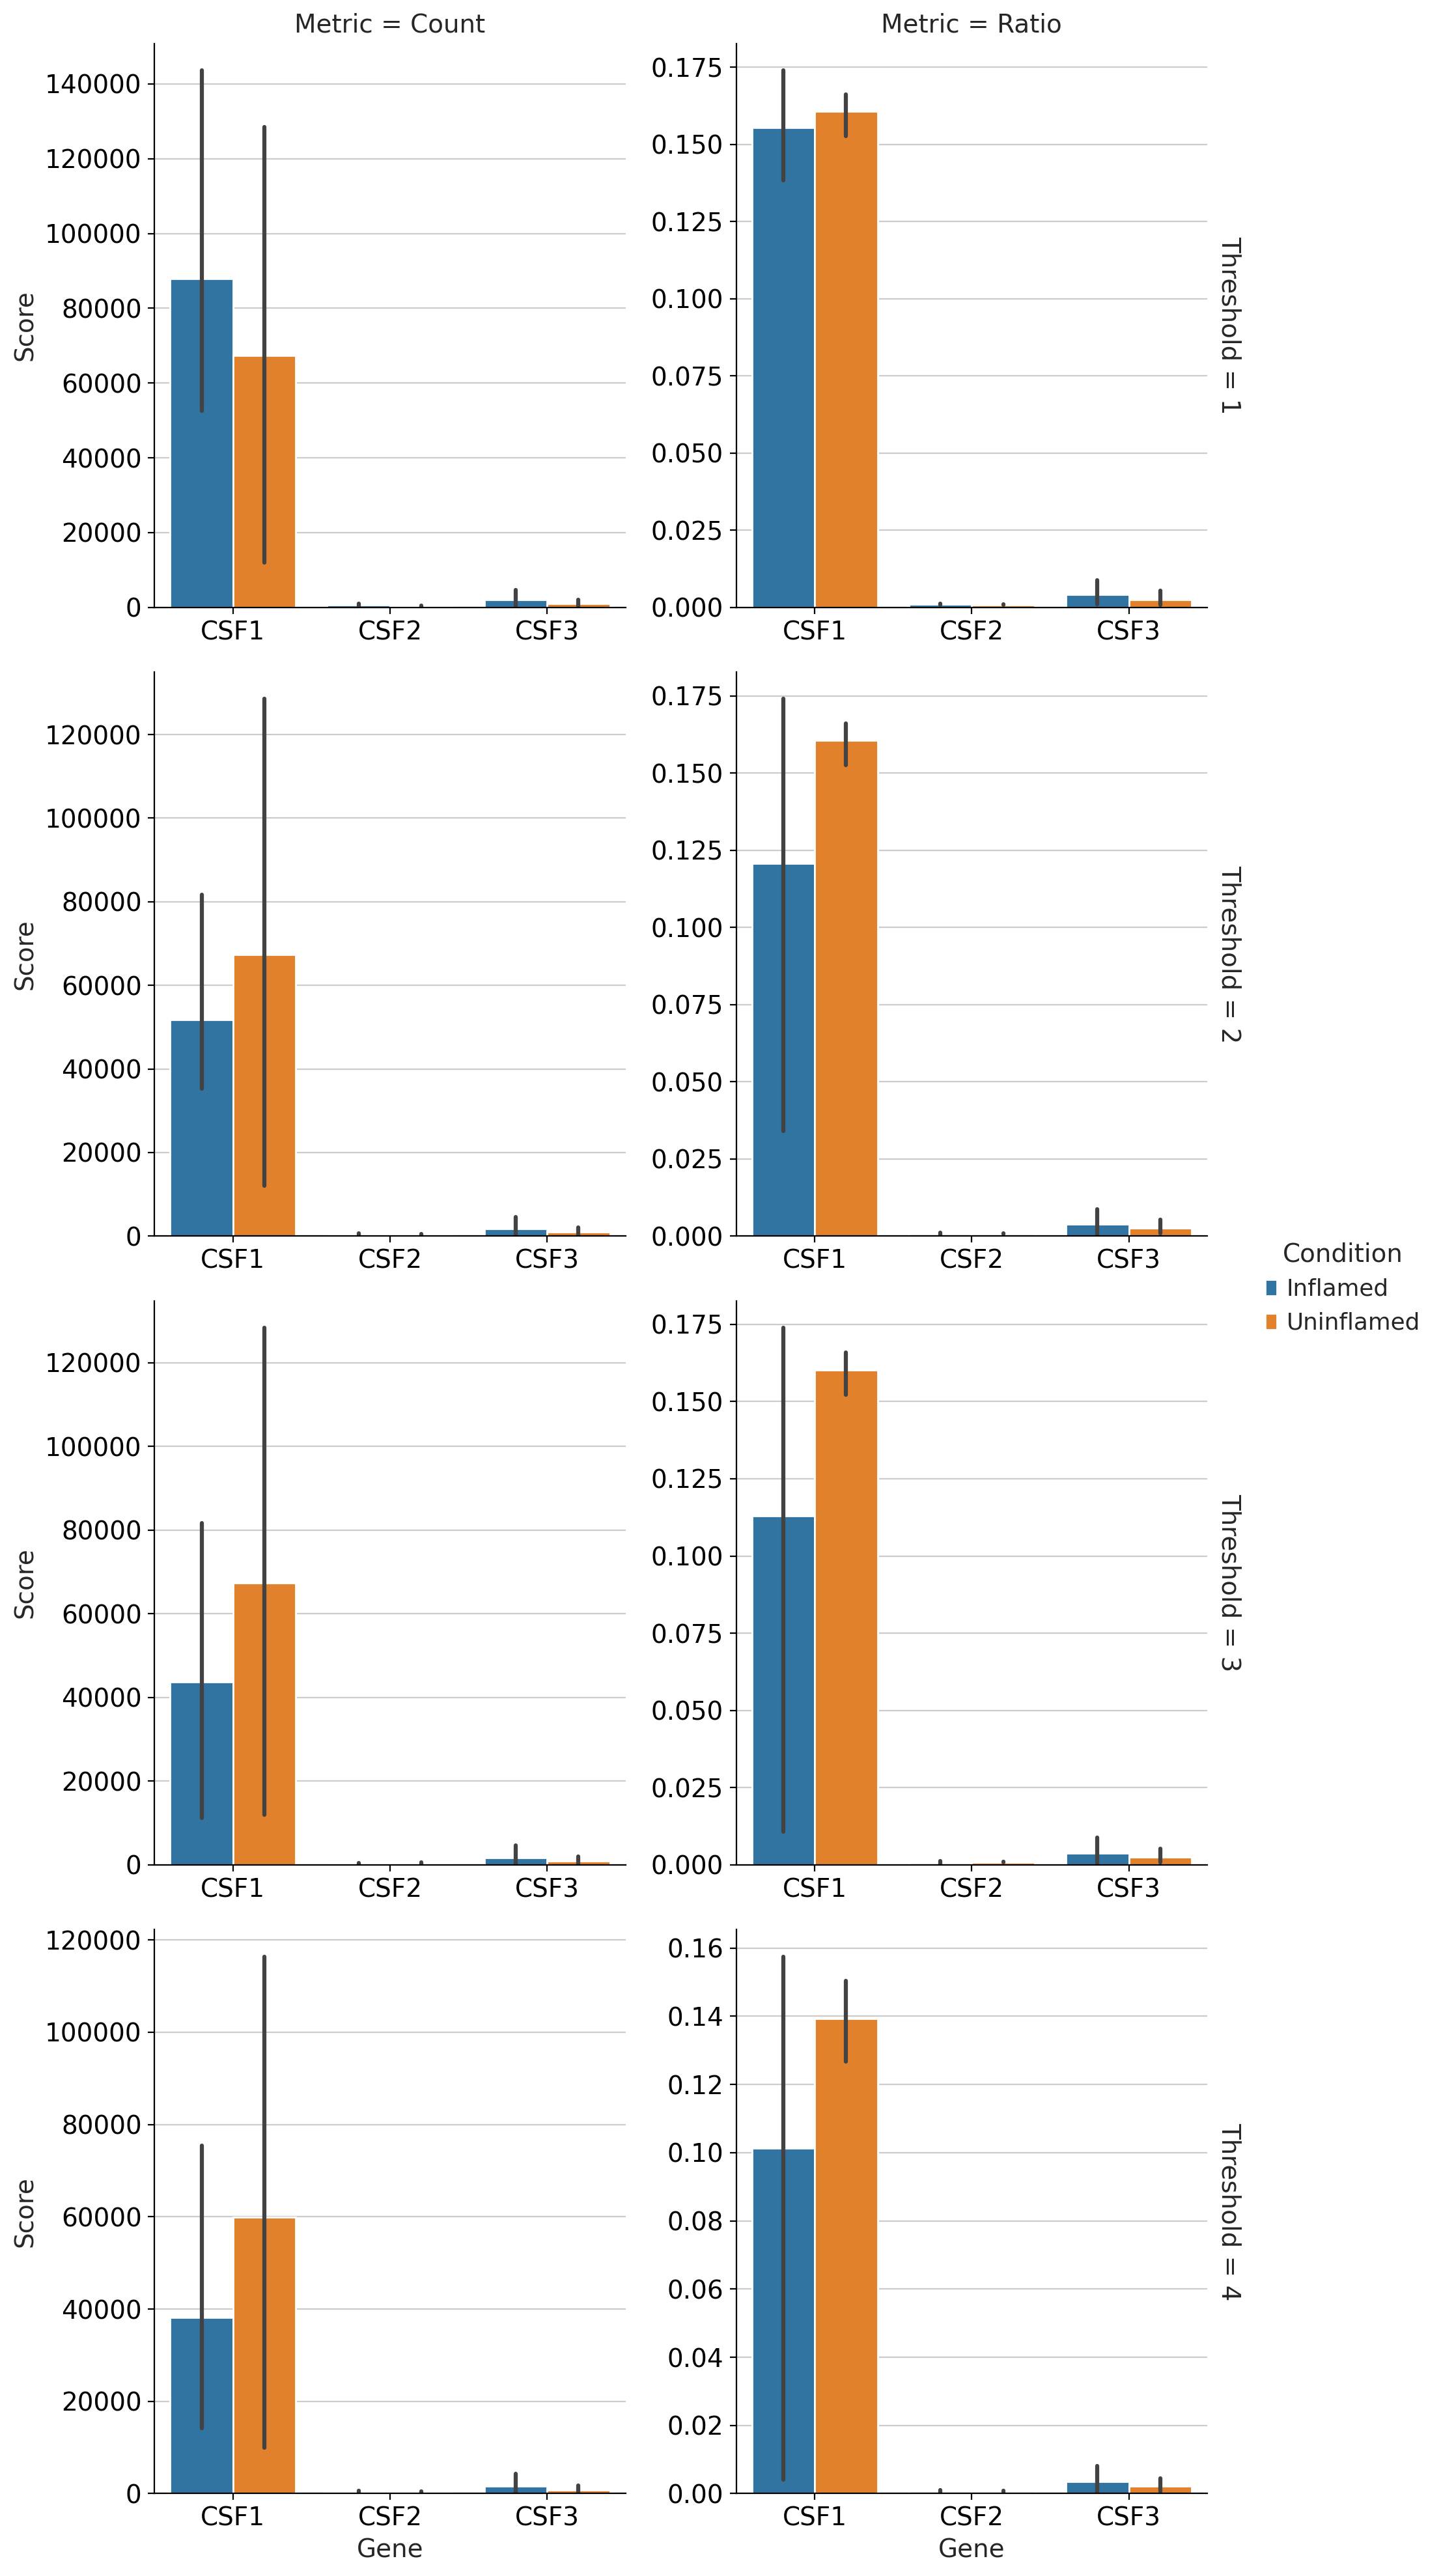

In [12]:
import seaborn as sb
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

csfp = csf[csf.Condition.isin(["Inflamed", "Uninflamed"])].set_index(
    "Condition", append=True)[["Count", "Ratio"]].rename_axis(
        "Metric", axis=1).stack().to_frame("Score")
fig = sb.catplot(csfp.reset_index(), x="Gene", y="Score", col="Metric",
                 margin_titles=True,
                 row="Threshold", hue="Condition", kind="bar",
                 sharex=False, sharey=False)
for a in fig.axes[:, 1]:
    a.set_ylim([0, max(csfp.Ratio, 0.3)])
fig.fig.tight_layout()

In [ ]:
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed")),
    (("CSF1", "Uninflamed"), ("CSF1", "Inflamed")),
    (("CSF2", "Uninflamed"), ("CSF2", "Inflamed"))
]

ant = Annotator(None, pairs)
fig.map_dataframe(ant.plot_and_annotate_facets, plot_params=arg,
                  plot="boxplot", annotation_func="apply_test",
                  configuration={"test": "wilcox"})
plt.show()

In [ ]:
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed"))
]

ant = Annotator(None, pairs)
fig.map_dataframe(ant.plot_and_annotate_facets, plot_params=arg,
                  plot="boxplot", annotation_func="apply_test",
                  configuration={"test": "wilcox"})
plt.show()

In [ ]:
csfp = csf.reset_index()
arg = dict(x="Gene", y="Ratio", hue="Condition", hue_order=[
    "Inflamed", "Uninflamed"], order=["CSF1", "CSF2"])
fig = sb.catplot(kind="bar", errorbar="se", row="Threshold", data=csfp, **arg)
# fig.map(sb.stripplot, arg["x"], arg["y"], arg["hue"],
#         hue_order=arg["hue_order"], order=arg["order"], dodge=True,
#         palette=sb.color_palette(), alpha=0.6, linewidth=1)
pairs = [
    (("CSF1", "Inflamed"), ("CSF2", "Inflamed")),
    (("CSF1", "Uninflamed"), ("CSF2", "Uninflamed")),
    (("CSF1", "Uninflamed"), ("CSF1", "Inflamed")),
    (("CSF2", "Uninflamed"), ("CSF2", "Inflamed"))
]
for t, ax in fig.axes_dict.items():
        annot = Annotator(ax, pairs, **arg, data=csfp[csfp.Threshold == t])
        annot.configure(test="Mann-Whitney", text_format="simple",
                        loc="inside", verbose=2)
        annot.apply_test().annotate()

In [ ]:
csfp = csf[csf.Condition.isin(["Inflamed", "Uninflamed"])].set_index(
    "Condition", append=True)[["Count", "Ratio"]].rename_axis(
        "Metric", axis=1).stack().to_frame("Score")
fig = sb.catplot(csfp, x="Gene", y="Score", col="Metric", margin_titles=True,
                 row="Threshold", kind="bar", errorbar="se",
                 sharex=False, sharey=False)
for a in fig.axes[:, 1]:
    a.set_ylim([0, max([csf.Ratio.max(), 0.3])])
fig.fig.tight_layout()

## Aligned Images

In [ ]:
landmarks = ShapesModel.parse(
    np.array([[10556.699, 7829.764], [13959.155, 13522.025], [10621.200, 17392.116]]), geometry=0, radius=500
)
visium_sdata["visium_landmarks"] = visium_landmarks

xenium_landmarks = ShapesModel.parse(
    np.array([[9438.385, 13933.017], [24847.866, 5948.002], [34082.584, 15234.235]]), geometry=0, radius=500
)
xenium_sdata["xenium_landmarks"] = xenium_landmarks

In [ ]:
import spatialdata_io as sdio
from spatialdata.models import ShapesModel

fai = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue.ome.tif")
faa = os.path.join(
    "~/corescpy/examples/data/spatial",
    "Stricture-50452C__P53Red_P16Green_DAPIBlue_matrix.csv")

img = sdio.xenium_aligned_image(fai, faa)